In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.utils import resample
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.api import add_constant
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression, Ridge
import pickle

import pymannkendall
from typing import Tuple, Union

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

d:\data_science\python\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\data_science\python\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\data_science\python\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Dataframe containing thr prepared datset
df = pd.read_csv("wide_format_drugs_years.csv")

Text(0.5, 1.0, 'Presence of Nulls in the dataset')

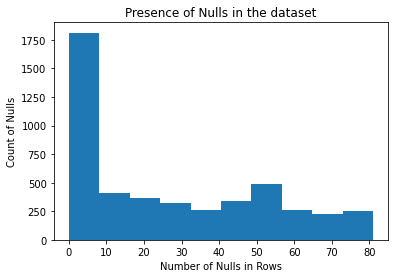

In [3]:
# Null analytics
plt.hist(df.isnull().sum(axis=1))
plt.xlabel('Number of Nulls in Rows')
plt.ylabel("Count of Nulls")
plt.title("Presence of Nulls in the dataset")

In [4]:
# Dealing with Null values
def remove_invalid_data(series):
    # Convert to pandas Series if it's not already one
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
        
    series.index = np.arange(len(series))
        
    # Find the index of the first non-NaN value
    first_valid_index = series.first_valid_index()
    if first_valid_index is None:
        return series  # Return empty series if all are NaNs
    
    last_valid_index = series.last_valid_index()
    series_1 = series[first_valid_index:last_valid_index+1]
    series_1.dropna(inplace=True)
    
    if last_valid_index == len(series)-1:
        return series_1
    else:
        zero_length = len(series) - last_valid_index - 1
        series = pd.concat([series_1, pd.Series(np.zeros(zero_length))], axis=0)
    
    return series

In [5]:
# Dataframe meta info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4734 entries, 0 to 4733
Data columns (total 88 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Brand Name                                        4734 non-null   object 
 1   Generic Name                                      4734 non-null   object 
 2   Total Spending_2012                               2265 non-null   float64
 3   Total Dosage Units_2012                           2265 non-null   float64
 4   Total Claims_2012                                 2265 non-null   float64
 5   Total Beneficiaries_2012                          2251 non-null   float64
 6   Average Spending Per Dosage Unit (Weighted)_2012  2265 non-null   float64
 7   Average Spending Per Claim_2012                   2265 non-null   float64
 8   Average Spending Per Beneficiary_2012             2251 non-null   float64
 9   Total Spending_2013

In [6]:
# Descriptive Statistics
df.describe()

,Total Spending_2012,Total Dosage Units_2012,Total Claims_2012,Total Beneficiaries_2012,Average Spending Per Dosage Unit (Weighted)_2012,Average Spending Per Claim_2012,Average Spending Per Beneficiary_2012,Total Spending_2013,Total Dosage Units_2013,Total Claims_2013,Total Beneficiaries_2013,Average Spending Per Dosage Unit (Weighted)_2013,Average Spending Per Claim_2013,Average Spending Per Beneficiary_2013,Total Spending_2014,Total Dosage Units_2014,Total Claims_2014,Total Beneficiaries_2014,Average Spending Per Dosage Unit (Weighted)_2014,Average Spending Per Claim_2014,Average Spending Per Beneficiary_2014,Outlier Flag_2014,Total Spending_2015,Total Dosage Units_2015,Total Claims_2015,Total Beneficiaries_2015,Average Spending Per Dosage Unit (Weighted)_2015,Average Spending Per Claim_2015,Average Spending Per Beneficiary_2015,Outlier Flag_2015,Total Spending_2016,Total Dosage Units_2016,Total Claims_2016,Total Beneficiaries_2016,Average Spending Per Dosage Unit (Weighted)_2016,Average Spending Per Claim_2016,Average Spending Per Beneficiary_2016,Outlier Flag_2016,Total Spending_2017,Total Dosage Units_2017,Total Claims_2017,Total Beneficiaries_2017,Average Spending Per Dosage Unit (Weighted)_2017,Average Spending Per Claim_2017,Average Spending Per Beneficiary_2017,Outlier Flag_2017,Total Spending_2018,Total Dosage Units_2018,Total Claims_2018,Total Beneficiaries_2018,Average Spending Per Dosage Unit (Weighted)_2018,Average Spending Per Claim_2018,Average Spending Per Beneficiary_2018,Outlier Flag_2018,Total Spending_2019,Total Dosage Units_2019,Total Claims_2019,Total Beneficiaries_2019,Average Spending Per Dosage Unit (Weighted)_2019,Average Spending Per Claim_2019,Average Spending Per Beneficiary_2019,Outlier Flag_2019,Total Spending_2020,Total Dosage Units_2020,Total Claims_2020,Total Beneficiaries_2020,Average Spending Per Dosage Unit (Weighted)_2020,Average Spending Per Claim_2020,Average Spending Per Beneficiary_2020,Outlier Flag_2020,Total Spending_2021,Total Dosage Units_2021,Total Claims_2021,Total Beneficiaries_2021,Average Spending Per Dosage Unit (Weighted)_2021,Average Spending Per Claim_2021,Average Spending Per Beneficiary_2021,Outlier Flag_2021,Total Spending_2022,Total Dosage Units_2022,Total Claims_2022,Total Beneficiaries_2022,Average Spending Per Dosage Unit (Weighted)_2022,Average Spending Per Claim_2022,Average Spending Per Beneficiary_2022,Outlier Flag_2022
count,2265.00,2265.00,2265.00,2251.00,2265.00,2265.00,2251.00,2576.00,2576.00,2576.00,2556.00,2576.00,2576.00,2556.00,3061.00,3061.00,3061.00,3135.00,3061.00,3061.00,3011.00,2686.00,3302.00,3302.00,3302.00,3368.00,3302.00,3302.00,3237.00,2907.00,3457.00,3457.00,3457.00,3522.00,3457.00,3457.00,3383.00,3064.00,3383.00,3383.00,3383.00,3399.00,3383.00,3383.00,3281.00,3260.00,3491.00,3491.00,3491.00,3446.00,3491.00,3491.00,3339.00,3480.00,3535.00,3535.00,3535.00,3439.00,3535.00,3535.00,3381.00,3530.00,3583.00,3583.00,3583.00,3440.00,3583.00,3583.00,3408.00,3578.00,3585.00,3585.00,3585.00,3402.00,3585.00,3585.00,3398.00,3579.00,3575.00,3575.00,3575.00,3386.00,3575.00,3575.00,3386.00,3562.00
mean,36575984.72,31791797.16,496845.62,124564.81,102.11,673.76,3251.22,40159013.30,36083366.04,571774.15,148807.21,119.31,862.99,4377.66,43260180.22,35195132.96,540091.21,138811.67,132.76,1008.00,4788.91,0.07,44725352.93,33931309.33,511011.48,134600.40,153.51,1318.99,5619.49,0.08,44709518.65,33214935.86,489901.76,132703.68,169.50,1482.26,7515.60,0.07,46021261.86,30556863.14,428579.49,119732.37,202.68,1769.99,8745.78,0.08,47930589.70,29963255.96,410230.18,118574.64,238.30,2102.68,9967.73,0.10,51894067.94,31002256.88,417992.26,122681.98,275.60,2419.88,11731.36,0.10,55720167.88,31638433.25,416083.12,119242.33,317.52,2739.44,13898.42,0.10,60521972.74,31928753.24,418710.17,124596.82,349.66,2984.93,15461.86,0.11,67253643.17,33486508.82,431978.39,131893.14,495.24,3441.06,17524.45,0.11
std,140030384.05,138047552.24,2177886.94,475117.17,1233.79,2733.31,17355.28,152896468.01

# Sense of the entire data

### Total Spending

Text(0, 0.5, 'Total Spending')

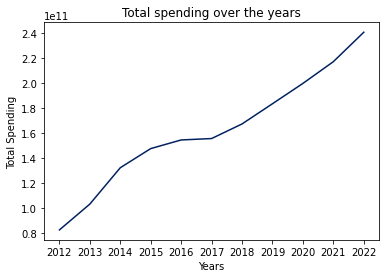

In [8]:
x = [i.rsplit('_')[-1] for i in df.columns[2:] if 'Total Spending' in i]
plt.plot(x, df[[i for i in df.columns if 'Total Spending' in i]].sum(axis=0).values, color='#002060')
plt.title("Total spending over the years")
plt.xlabel('Years')
plt.ylabel("Total Spending")

Generally on the rise!

In [46]:
# Aggregating data over total spending
agg_spend_data = df[[i for i in df.columns if 'Total Spending' in i]].sum(axis=0).values

# Calculating year on year increase
increase_perc_year_over_year_spend = []
for i in range(len(agg_spend_data)-1):
    increase_perc_year_over_year_spend.append(1+((agg_spend_data[i+1] - agg_spend_data[i])/(np.abs(agg_spend_data[i]))))

In [47]:
# Creating dummy index for years in year over year increase table
x = np.arange(len(increase_perc_year_over_year_spend)).reshape(-1, 1)

# Fit a polynomial regression model to forecast total spending in the future
# Polynomial model to make data 2D
poly_features = PolynomialFeatures(degree=2)
# Fit the polynomial model
x_poly = poly_features.fit_transform(x)
# Define Ridge model
poly_model = Ridge()
# Train the Ridge Regression model
poly_model.fit(x_poly, increase_perc_year_over_year_spend)

Ridge()

In [48]:
# Saving the polynomial feature generation model
with open('poly_feature_spend.pkl','wb') as f:
    pickle.dump(poly_features,f)

# Saving the Ridge Regression model
with open('poly_model_spend','wb') as f:
    pickle.dump(poly_model,f)

### Total Dosage Units

Text(0, 0.5, 'Total Dosage Units')

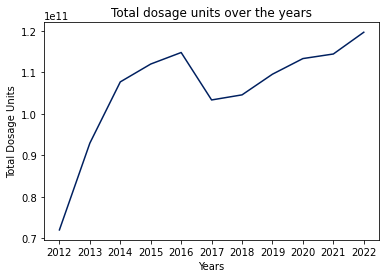

In [10]:
x = [i.rsplit('_')[-1] for i in df.columns[2:] if 'Total Dosage Units' in i]
plt.plot(x, df[[i for i in df.columns if 'Total Dosage Units' in i]].sum(axis=0).values, color='#002060')
plt.title("Total dosage units over the years")
plt.xlabel('Years')
plt.ylabel("Total Dosage Units")

A dip in 2017 and 2018

### Total Claims

Text(0, 0.5, 'Total Claims')

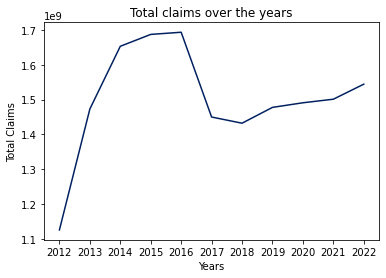

In [12]:
x = [i.rsplit('_')[-1] for i in df.columns[2:] if 'Total Claims' in i]
plt.plot(x, df[[i for i in df.columns if 'Total Claims' in i]].sum(axis=0).values, color='#002060')
plt.title("Total claims over the years")
plt.xlabel('Years')
plt.ylabel("Total Claims")

### Total Beneficiaries 

Text(0, 0.5, 'Total Beneficiaries')

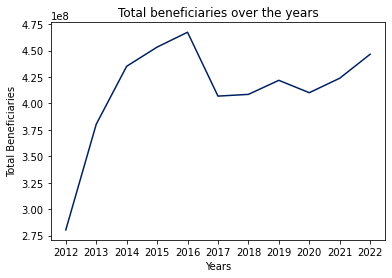

In [14]:
x = [i.rsplit('_')[-1] for i in df.columns[2:] if 'Total Beneficiaries' in i]
plt.plot(x, df[[i for i in df.columns if 'Total Beneficiaries' in i]].sum(axis=0).values, color='#002060')
plt.title("Total beneficiaries over the years")
plt.xlabel('Years')
plt.ylabel("Total Beneficiaries")

### Average Spending Per Dosage Unit (Weighted) 

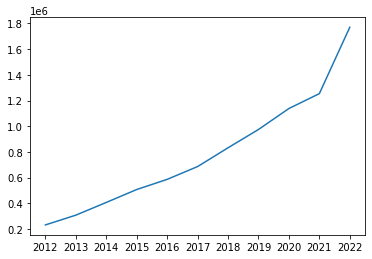

In [53]:
x = [i.rsplit('_')[-1] for i in drugs_20_total_dosage.columns[1:]]
plt.plot(x, df[[i for i in drugs_20.columns if 'Average Spending Per Dosage Unit (Weighted)' in i]].sum(axis=0).values)

In [49]:
# Aggregating data over Average Spending Per Dosage Unit
agg_spend_data = df[[i for i in df.columns if 'Average Spending Per Dosage Unit (Weighted)' in i]].sum(axis=0).values

# Calculating year on year increase
increase_perc_year_over_year_spend = []
for i in range(len(agg_spend_data)-1):
    increase_perc_year_over_year_spend.append(1+((agg_spend_data[i+1] - agg_spend_data[i])/(np.abs(agg_spend_data[i]))))


x = np.arange(len(increase_perc_year_over_year_spend)).reshape(-1, 1)

# Calculating year on year increase
# Polynomial model to make data 2D
poly_features = PolynomialFeatures(degree=2)
# Fit the polynomial model
x_poly = poly_features.fit_transform(x)
# Define Ridge model
poly_model = Ridge()
# Train the Ridge Regression model
poly_model.fit(x_poly, increase_perc_year_over_year_spend)

# Saving the polynomial feature generation model
with open('poly_feature_avg_spend_dosage.pkl','wb') as f:
    pickle.dump(poly_features,f)

# Saving the Ridge Regression model
with open('poly_model_avg_spend_dosage','wb') as f:
    pickle.dump(poly_model,f)

### Average Spending Per Claim

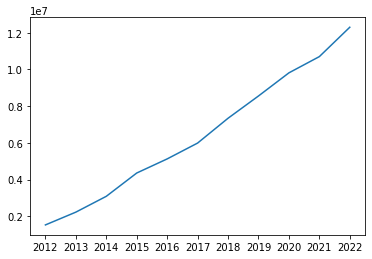

In [54]:
x = [i.rsplit('_')[-1] for i in drugs_20_total_dosage.columns[1:]]
plt.plot(x, df[[i for i in drugs_20.columns if 'Average Spending Per Claim' in i]].sum(axis=0).values)

In [50]:
# Aggregating data over Average Spending Per Claim
agg_spend_data = df[[i for i in df.columns if 'Average Spending Per Claim' in i]].sum(axis=0).values

# Calculating year on year increase
increase_perc_year_over_year_spend = []
for i in range(len(agg_spend_data)-1):
    increase_perc_year_over_year_spend.append(1+((agg_spend_data[i+1] - agg_spend_data[i])/(np.abs(agg_spend_data[i]))))

x = np.arange(len(increase_perc_year_over_year_spend)).reshape(-1, 1)

# Fit a polynomial regression model to forecast Average Spending Per Claim in the future
# Polynomial model to make data 2D
poly_features = PolynomialFeatures(degree=2)
# Fit the polynomial model
x_poly = poly_features.fit_transform(x)
# Define Ridge model
poly_model = Ridge()
# Train the Ridge Regression model
poly_model.fit(x_poly, increase_perc_year_over_year_spend)

# Saving the polynomial feature generation model
with open('poly_feature_avg_spend_claim.pkl','wb') as f:
    pickle.dump(poly_features,f)

# Saving the Ridge Regression model
with open('poly_model_avg_spend_claim','wb') as f:
    pickle.dump(poly_model,f)

### Average Spending Per Beneficiary

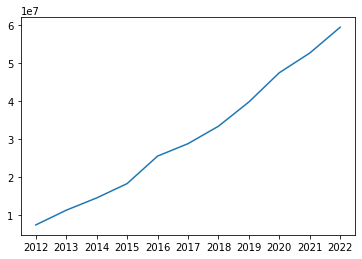

In [55]:
x = [i.rsplit('_')[-1] for i in drugs_20_total_dosage.columns[1:]]
plt.plot(x, df[[i for i in drugs_20.columns if 'Average Spending Per Beneficiary' in i]].sum(axis=0).values)

In [51]:
# Aggregating data over Average Spending Per Beneficiary
agg_spend_data = df[[i for i in df.columns if 'Average Spending Per Beneficiary' in i]].sum(axis=0).values

# Calculating year on year increase
increase_perc_year_over_year_spend = []
for i in range(len(agg_spend_data)-1):
    increase_perc_year_over_year_spend.append(1+((agg_spend_data[i+1] - agg_spend_data[i])/(np.abs(agg_spend_data[i]))))

x = np.arange(len(increase_perc_year_over_year_spend)).reshape(-1, 1)

# Fit a polynomial regression model to forecast total spending in the future
# Polynomial model to make data 2D
poly_features = PolynomialFeatures(degree=2)
# Fit the polynomial model
x_poly = poly_features.fit_transform(x)
# Define Ridge model
poly_model = Ridge()
# Train the Ridge Regression model
poly_model.fit(x_poly, increase_perc_year_over_year_spend)

# Saving the polynomial feature generation model
with open('poly_feature_avg_spend_bene.pkl','wb') as f:
    pickle.dump(poly_features,f)

# Saving the Ridge Regression model
with open('poly_model_avg_spend_bene','wb') as f:
    pickle.dump(poly_model,f)

# Plotting 7 measures for 20 random drugs

In [62]:
# Pick 20 random drugs
drugs_20 = df.sample(n=5, random_state=41)

### Plotting Total Spending

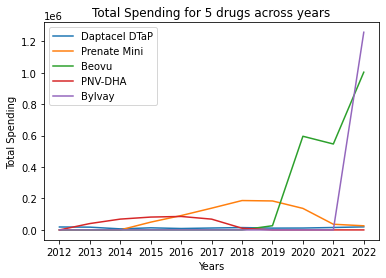

In [64]:
drugs_20_total_spending = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Total Spending' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_spending.columns[1:]]
for index, row in drugs_20_total_spending.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.legend()

plt.title("Total Spending for 5 drugs across years")
plt.xlabel("Years")
plt.ylabel("Total Spending")
plt.show()

### Total Dosage Units

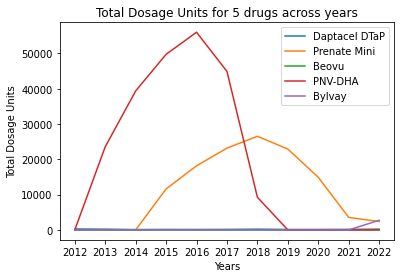

In [69]:
drugs_20_total_dosage = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Total Dosage Units' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_dosage.columns[1:]]
for index, row in drugs_20_total_dosage.iterrows():
    plt.plot(x, row.values[1:], label=row[0])

plt.title("Total Dosage Units for 5 drugs across years")
plt.xlabel("Years")
plt.ylabel("Total Dosage Units")
plt.legend()
plt.show()

### Total Claims

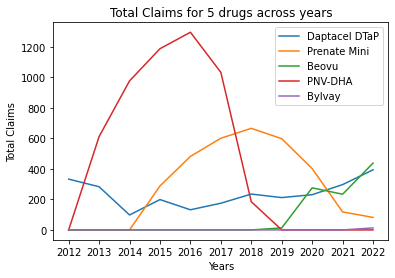

In [70]:
drugs_20_total_claims = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Total Claims' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_claims.columns[1:]]
for index, row in drugs_20_total_claims.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.title("Total Claims for 5 drugs across years")
plt.xlabel("Years")
plt.ylabel("Total Claims")
plt.legend()
plt.show()

### Total Beneficiaries

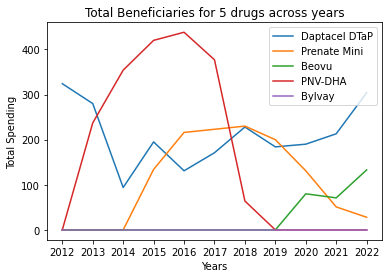

In [68]:
drugs_20_total_beneficiaries = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Total Beneficiaries' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_beneficiaries.columns[1:]]
for index, row in drugs_20_total_beneficiaries.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.title("Total Beneficiaries for 5 drugs across years")
plt.xlabel("Years")
plt.ylabel("Total Beneficiaries")
plt.legend()
plt.show()

### Average Spending Per Dosage Unit (Weighted)

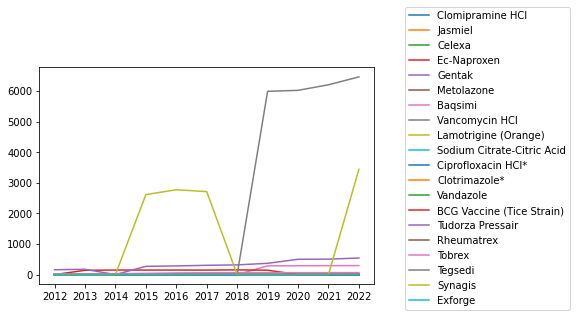

In [41]:
drugs_20_total_avg_spend_dosage = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Average Spending Per Dosage Unit (Weighted)' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_avg_spend_dosage.columns[1:]]
for index, row in drugs_20_total_avg_spend_dosage.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.legend()
plt.show()

### Average Spending Per Claim

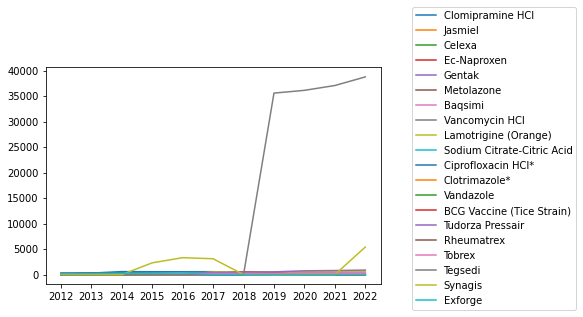

In [42]:
drugs_20_total_avg_spend_claim = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Average Spending Per Claim' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_avg_spend_claim.columns[1:]]
for index, row in drugs_20_total_avg_spend_claim.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.legend(bbox_to_anchor=(1.6, 1.3), loc="upper right")
plt.show()

### Average Spending Per Beneficiary

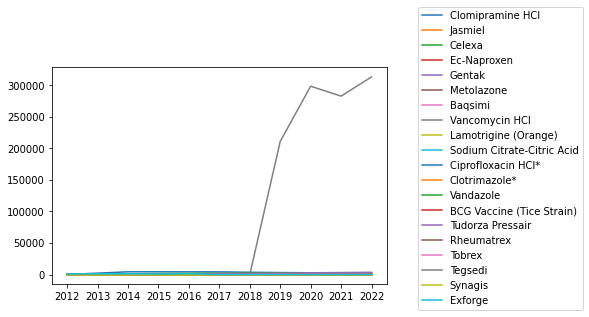

In [43]:
drugs_20_total_avg_spend_bene = drugs_20.iloc[:][['Brand Name']+[i for i in drugs_20.columns if 'Average Spending Per Beneficiary' in i]]
x = [i.rsplit('_')[-1] for i in drugs_20_total_avg_spend_bene.columns[1:]]
for index, row in drugs_20_total_avg_spend_bene.iterrows():
    plt.plot(x, row.values[1:], label=row[0])
    
plt.legend(bbox_to_anchor=(1.6, 1.3), loc="upper right")
plt.show()

## ** There's no point calculating trend or seasonality because there aren't many data points to effectively capture that. But we will still try. **

# Rule of Thumb for nlags = N/4, which is 3 in our case

# Correlation for each of the 7 variables

I am doing this to identify which features is most dependent on its previous states

### Calculating correlation

In [97]:
ar_lag_values = []

for i in range(df.shape[0]):
    d = df.iloc[i][[i for i in drugs_20.columns if 'Total Spending' in i]]
    values = pd.DataFrame(d.values)
    
    # Calculate lower and upper bound for confidence interval
    bootstrapped_acfs = []
    for _ in range(10):  # Number of bootstrap samples
        sample = resample(values)
        bootstrapped_acfs.append(acf(sample, nlags=3))
    
    # Calculate upper bound
    upper_bounds = np.percentile(bootstrapped_acfs, 80, axis=0)
    
    # ACF calculation
    acf_values = acf(values, nlags=3)
    
    # Significant lags
    significant_lags = []
    for i in range(10):
        if acf_values[i] >= upper_bounds[i]:
            significant_lags.append(1)
        else:
            significant_lags.append(0)
            
    # Wherever the first zero occurs,take that as AR lag value
    ar_lag_value = np.where(np.array(significant_lags) == 0)[0][0] + 1
    
    # Save the AR lag value
    ar_lag_values.append(ar_lag_value)
    

# Removing the errornous data from the AR lag values
ar_lag_values = [i for i in ar_lag_values if i != 1]

pd.Series(ar_lag_values).describe()

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

invalid value encountered in divide

d:\data_science\python\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning:

inval

count   4292.00
mean       3.87
std        0.89
min        2.00
25%        3.00
50%        4.00
75%        5.00
max        7.00
dtype: float64

These values show the descriptive statistics of period in Autocorrelation. The data is even spread across the quartiles which suggest there might not be a significant lag that we can rely on. So, we revert back to the thumb rule in case we decide to use it!

# Checking for Heteroscedasticity

#### Breusch–Pagan test

In [176]:
p_value_list = []
for index, row in df.iterrows():
    spending_series = row['2012': '2022']+1e-5
    X = sm.add_constant(np.arange(len(spending_series)))  # adding a constant for intercept
    y = spending_series.values

    # Fit a simple linear regression model
    model = sm.OLS(y, X).fit()

    # Extract residuals
    residuals = model.resid

    # Apply the Breusch-Pagan test on the residuals
    test_stat, p_value, _, _ = het_breuschpagan(residuals, X)
    p_value_list.append(p_value)
    #print(f'Breusch-Pagan Test Statistic: {test_stat}, p-value: {p_value}')

In [177]:
pd.Series(p_value_list).describe()

count   1446.00
mean       0.29
std        0.28
min        0.00
25%        0.06
50%        0.18
75%        0.45
max        1.00
dtype: float64

In [ ]:
# Number of drugs that have a p-value higher than 0.05 alpha to show homoskedasticity
sum(i > 0.05 for i in p_value_list)

With the mean being 0.33 and median being 0.20, it can be assumed that most of time series has homoscedasticity

# Trend

In [4]:
df = pd.read_csv("wide_format_drugs_years.csv")
df = df[['Brand Name', 'Total Spending_2012',
        'Total Spending_2013', 'Total Spending_2014',
        'Total Spending_2015', 'Total Spending_2016',
        'Total Spending_2017', 'Total Spending_2018',
        'Total Spending_2019', 'Total Spending_2020',
        'Total Spending_2021', 'Total Spending_2022']]

df_orig = df.copy()
df.columns = ['Brand Name']+[i.rsplit('_')[-1] for i in df.columns[1:]]

#### Mann Kendall test

In [14]:
def trend(series: Union[np.ndarray, pd.Series, pd.DataFrame], 
          test: str ='consensus',
          tests: dict = {
            'hamed_rao': pymannkendall.hamed_rao_modification_test,
            'normal': pymannkendall.original_test,
            'yue_wang': pymannkendall.yue_wang_modification_test
           }) -> Tuple[list, float]:

    trend = 0.
    p_vals = []
    
    results = pymannkendall.hamed_rao_modification_test(series)

    # consensus average
    return results.p, results.trend, results.slope

In [15]:
trends = []
p_values = []
slopes = []

for index, row in df.iterrows():
    spending_series = row['2012': '2022']+1e-5
    # Considering time series which do not have more than 7 nulls
    # Mann Kendall requires atleast 4 points
    if spending_series.isna().sum() < 7:
        p_value, tre, slope = trend(spending_series)
        trends.append(tre)
        p_values.append(p_value)
        slopes.append(slope)

temp_df = pd.DataFrame({'p':p_values, 't':trends, 's':slopes})

In [19]:
temp_df['t'].value_counts()

t
no trend      1956
increasing     913
decreasing     911
Name: count, dtype: int64

In [123]:
sum(i < 0.05 for i in p_values)

1824

So, 1824 of the series have a p-value lower than 0.05. Significant.

In [89]:
trends_df = pd.DataFrame({'trend':trends, 'p': p_values})

In [90]:
trends_df[trends_df['trend'] != 0].describe()

,trend,p
count,2703.00,2700.00
mean,0.59,0.01
std,0.81,0.01
min,-1.00,0.00
25%,1.00,0.00
50%,1.00,0.00
75%,1.00,0.01
max,1.00,0.11


So, it is very sure of the data points which have trends since more than 75% of the data has p-value less than 0.05

In [91]:
trends_df[trends_df['trend'] == 0].describe()

,trend,p
count,2031.00,2030.00
mean,0.00,0.35
std,0.00,0.30
min,0.00,0.04
25%,0.00,0.11
50%,0.00,0.23
75%,0.00,0.58
max,0.00,1.00


It is very unsure of the datapoints that do not have a trend. So, these are unreliable.

2703 drugs show trend. <br>
2031drugs don\'t show trend.

That means there is a trend for more than half the data and very sure of it!

# Seasonality

In [ ]:
for index, row in df.iterrows():
    spending_series = row['2012': '2022']+1e-5
#     X = add_constant(pd.Series(range(len(spending_series)), index=spending_series.index))  # Time as the independent variable
#     test_stat, p_value, _, _ = het_breuschpagan(spending_series, X)
#     if p_value >= 0.05:
#         model = 'additive'
#     else:
#         model = 'multiplicative'

    stl = STL(spending_series, period=2)
    res = stl.fit()
    fig = res.plot()
    plt.show()

STL is Seasonal and Trend decomposition using Loess

There is no seasonality in the data based on visual inspection. STL is be a good option since the relationationship is certainly not linear in most cases.

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [ ]:
# Can PACF corroborate the conclusion?
for index, row in df.iterrows():
    spending_series = row['2012': '2022']+1e-5
    spending_series = remove_invalid_data(spending_series)
    sm.graphics.tsa.plot_pacf(spending_series, lags=(len(spending_series)//2)-1, method="ywm")
    plt.show()

PACF plots show no seasonality. There are so many reasons to believe the dataset is too small and the frequency of the data points being yearly doesn't lend itself to have a seasonal component.

# Checking stationarity

#### AD Fuller Test

In [8]:
# This function diffs the time series until it gets a good p-value
# If it doesn't, then stationarity cannot implied reliably.
def find_order_of_differencing(series):
    d = 0
    p_value = adfuller(series)[1]
    while p_value > 0.05:  # commonly used significance level
        d += 1
        try:
            test_result = adfuller(series.diff(d).dropna())
            p_value = test_result[1]
        except:
            return -1, -1
        
        if d > 5:  # To prevent excessive differencing which might lead to over differencing\
            return -1, -1
    return d, p_value

In [ ]:
p_values = []
ds = []
p_vals = []
for index, row in df.iterrows():
    spending_series = row['2012': '2022']+1e-5
    spending_series = remove_invalid_data(spending_series)
    try:
        p_value = adfuller(spending_series)[1]
        p_values.append(p_value)
        if p_value >= 0.05:
            d, p_value = find_order_of_differencing(spending_series)
            ds.append(d)
            p_vals.append(p_value)
    except Exception as e:
        print(e)
        print(len(spending_series))

In [174]:
td = pd.DataFrame({'p':p_vals, 'd': ds})
td[(td['p'] != -1)]['p'].describe()

count   2070.00
mean       0.01
std        0.01
min        0.00
25%        0.00
50%        0.00
75%        0.01
max        0.05
Name: p, dtype: float64

In [161]:
pd.Series(p_values).describe()

count   4201.00
mean       0.44
std        0.38
min        0.00
25%        0.02
50%        0.41
75%        0.80
max        1.00
dtype: float64

In [162]:
sum(i < 0.05 for i in p_values)

1255

Out of 4201 time series, only 1255 have a significant p-value implying stationarity.
